In [14]:
# !pip install suite2p
# !pip install scanimage-tiff-reader
# !pip install -U scikit-image
# !pip install tiffile
# !pip install --upgrade scipy
# !pip install cmocean

    100% |████████████████████████████████| 225kB 5.7MB/s 


## Calcium Imaging analysis

### Load required libraries

In [15]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
# from skimage.viewer import ImageViewer
# import skimage
import importlib
# from tiffStacks import sciscanTiff
import tiffStacks as tst
cmap = tst.phaseColormap()
import cmocean

In [2]:
cd '/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/ChAT_gCaMP6s_example2/'

/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/ChAT_gCaMP6s_example2


### Load tiff file and run registration

In [3]:
fpath = 'ChAT_gCaMP6s_example2';
fname = '20190520_L03_04Bars_Original';
ts = tst.sciscanTiff(fpath,fname);
# ts.histRescaled() # display z-average
# ts.runRegistration() #use suite2P to register stack

In [4]:
from ScanImageTiffReader import ScanImageTiffReader as sitr
from skimage.viewer import ImageViewer
from tifffile import TiffFile, imwrite, xml2dict
import skimage
from scipy import signal
from tqdm import tqdm_notebook
import importlib

# creating class method to analyze DS in tiff after registration

Still missing:
    - wrapper to calculate DS in all pixels after thresholding
    - subplot 1 is missing stimulus artifact, and could use annotate, theta and barLims to draw stimulus arrows
    - this could be done by using subthreshold pixels across image
    - plotter of DSI as image
    - a way to load the correct bar settings

In [73]:
class rgTiff:
    """Python loader for registered tiff stack"""
    def __init__(self, filepath, filename):
        ### directories and paths ###
        self.filepath = filepath + '/'
        self.filename = 'rg_' + filename # path for registered tiff
        self.basedir = '/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/' + self.filepath + "analysis/"
        self.loadpath = self.basedir + self.filename + ".tif"
        ### Load tif file
        self.tif = sitr(self.loadpath)
        ### Run default methods
        self.metadata = self.getMetadata()
        self.barSettings = self.getBarSettings()
        self.dsThreshold = 0
        self.dsR = []
        self.dsT = []
        self.peakInd = []
        

    def getDSimg(self):
        flatData = self.getData().reshape(self.metadata['Lt'],self.metadata['Ly'] * self.metadata['Lx']);
        peakInd = np.zeros([self.barSettings['nDirections'], self.metadata['Ly'] * self.metadata['Lx']], dtype=int);
        dsR = np.zeros(self.metadata['Ly'] * self.metadata['Lx'])
        dsT = np.zeros(self.metadata['Ly'] * self.metadata['Lx'])
        theta = self.barSettings['theta']
        for i in tqdm_notebook(range(self.metadata['Ly']*self.metadata['Lx'])):
#         for i in tqdm_notebook(range(self.metadata['Ly'])):
            peakInd[:,i] = self.findPeaks(flatData[:,i]);
            dsR[i], dsT[i] = tst.calcDS(flatData[peakInd[:,i],i], theta)
        self.dsR = dsR.reshape(self.metadata['Ly'], self.metadata['Lx'])
        self.dsT = dsT.reshape(self.metadata['Ly'], self.metadata['Lx'])
            
    
    def getBarSettings(self):
        # need easy way to pull this data. Save csv from Sy2? read from h5 file? Ovation to Matlab to csv?
        barSettings = {
            'sI' : 1/self.metadata['samplingRate'], #sampling interval
            'prefrm' : 120, # bars preframes
            'stmfrm' : 580, # bars stimframes
            'tailfrm' : 120, # bars postframes
            'lagfrm' : 20, # frames for lag of response

            'nDirections' : 8, # number of bars
            'barW' : 68, # number of frames for a single bar
            'bar0' : 120, # frame index for first bar
            'barIBI' : 5, # inter-bar interval in frames

            'theta0' : 0, # angular direction of first bar
        }
        # bar directions assuming ordered presentation
        barSettings['theta'] = np.delete(np.mod(np.linspace(0+barSettings['theta0'],(2*np.pi)+barSettings['theta0'], num=barSettings['nDirections']+1),(2*np.pi)),-1)
        barSettings['barLims'] = np.multiply(range(barSettings['nDirections']+1),barSettings['barW'])+barSettings['bar0']
        barSettings['barLims'] = barSettings['barLims'] + np.multiply(range(barSettings['nDirections']+1),barSettings['barIBI'])
        # turning things from frames into seconds
        barSettings['barLimst'] = barSettings['barLims'] / self.metadata['samplingRate']
        barSettings['barWt'] = barSettings['barW'] / self.metadata['samplingRate']
        barSettings['barIBIt'] = barSettings['barIBI'] / self.metadata['samplingRate']
        return barSettings
    
    # CONVENIENCE
    def getMetadata(self):
        imgDescription = self.getImageDescription()
        metadata = {
            'Lt' : imgDescription['OME']['Image']['Pixels']['SizeT'],
            'Lx' : imgDescription['OME']['Image']['Pixels']['SizeX'],
            'Ly' : imgDescription['OME']['Image']['Pixels']['SizeY'],
            'nChannels' :  imgDescription['OME']['Image']['Pixels']['SizeC'],
            'realX' : np.multiply(imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeX'],1e6), # in um
            'realY' : np.multiply(imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeY'],1e6), # in um
            'realT' : imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeT'], # in s
            'samplingRate' : 0,
            'cellBodyDiameterX': 0,
            'cellBodyDiameterY': 0,
        }
        metadata['samplingRate'] = np.divide(metadata['Lt'],metadata['realT'])
        metadata['cellBodyDiameterX'] = np.divide(metadata['Lx'],metadata['realX']) * 5
        metadata['cellBodyDiameterY'] = np.divide(metadata['Ly'],metadata['realY']) * 5
        return metadata
    
    def getImageDescription(self):
        imgDescription = xml2dict(self.tif.description(0))
        return imgDescription
    
    def getData(self):
        img = self.tif.data();
        return img
    
    def getTAxis(self):
        tAx = range(self.metadata['Lt']) / self.metadata['samplingRate']
        return tAx

    def findPeaks(self, data):
        filtData = self.filterData(data);
        peakInd = np.zeros([self.barSettings['nDirections']], dtype = int)
        tempData = np.array(filtData[self.barSettings['prefrm']+self.barSettings['lagfrm']:self.barSettings['prefrm']+self.barSettings['stmfrm']+self.barSettings['lagfrm']], copy=True) 
        blankHalfWidth = round(self.barSettings['barW']*1.4/2)
        for b in range(self.barSettings['nDirections']):
            peakInd[b] = np.argmax(tempData)
            tempData[peakInd[b]-blankHalfWidth:peakInd[b]+blankHalfWidth]=0
            if peakInd[b] < self.barSettings['barW'] + self.barSettings['barIBI']:
                tempData[0:self.barSettings['barW'] + self.barSettings['barIBI']]=0
        peakInd = np.sort(peakInd)
        peakInd = peakInd + self.barSettings['prefrm'] + self.barSettings['lagfrm']
        return peakInd.astype(int)
    
    def plotPeaks_single(self, y = 0, x = 0):
        data = self.getData()[:,y,x]
        fData = self.filterData(data);
        peakInd = self.findPeaks(data);
        dsR, dsT = tst.calcDS(fData[peakInd], self.barSettings['theta'])
        tAx = self.getTAxis();
#         tAx = np.arange(np.size(data));
        fig = plt.figure(figsize=(20, 8))
        ax = plt.subplot(1, 2, 1)
        plt.plot(tAx, fData, lw=2, c='b')
        for b in range(self.barSettings['nDirections']):
#             rect = matplotlib.patches.Rectangle((self.barSettings['barLims'][b],0),
#                                                 self.barSettings['barW'],
#                                                 np.power(2,16),linewidth=1,edgecolor='none',facecolor='grey', alpha =.1)
            rect = matplotlib.patches.Rectangle((self.barSettings['barLimst'][b],0),
                                                self.barSettings['barWt'],
                                                np.power(2,16),linewidth=1,edgecolor='none',facecolor='grey', alpha =.1)
            ax.add_patch(rect)
        plt.scatter(tAx[peakInd], fData[peakInd], s=40, c='m', zorder=1000)
#         plt.xlim([100,220])
        ax = plt.subplot(1, 2, 2, projection='polar')
        plt.polar(np.concatenate((self.barSettings['theta'],[self.barSettings['theta'][0]])), np.concatenate((fData[peakInd],[fData[peakInd][0]])), 'r-')
        # plt.arrow(0,0,self.calcDS(fData[peakInd],self.barSettings['theta']), head_width=.1, head_length=1, length_includes_head=True, head_starts_at_zero=True, fc='k', ec='k')
        
        plt.annotate("", xy=(0, 0), xytext=(dsT, dsR), arrowprops=dict(arrowstyle="<|-"))
        
    
    # these methods could go into tiffStack.py
    @staticmethod
    def filterData(data):
        bwf_poles, bwf_freq = signal.butter(4, .1, btype='low', analog=False, output='ba', fs=None) #butterworth filter
        filtData = signal.filtfilt(bwf_poles,bwf_freq,data)
#         print('test filtering across sampling frequencies')
        return filtData
    


(840, 128, 256)
[120 193 266 339 412 485 558 631 704]


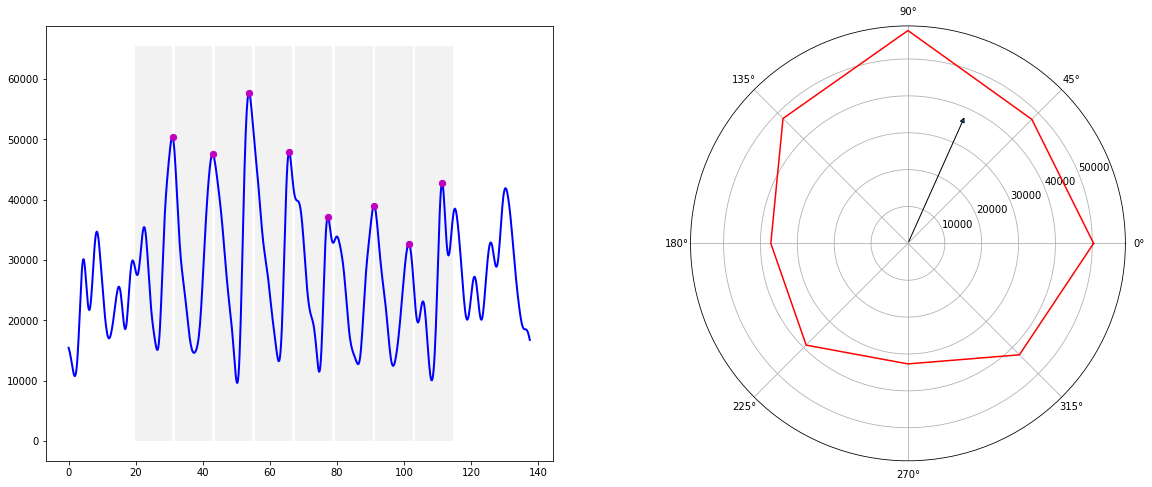

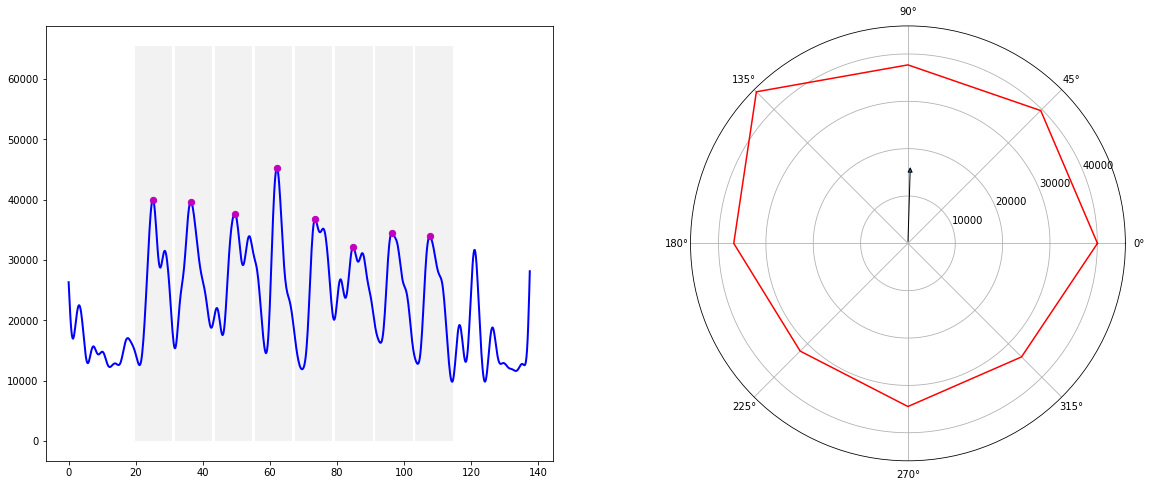

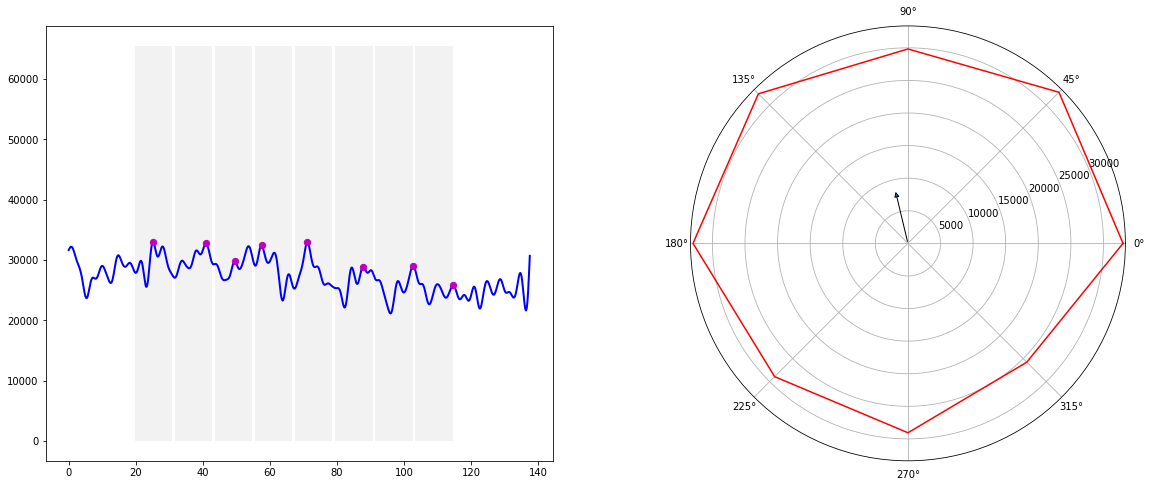

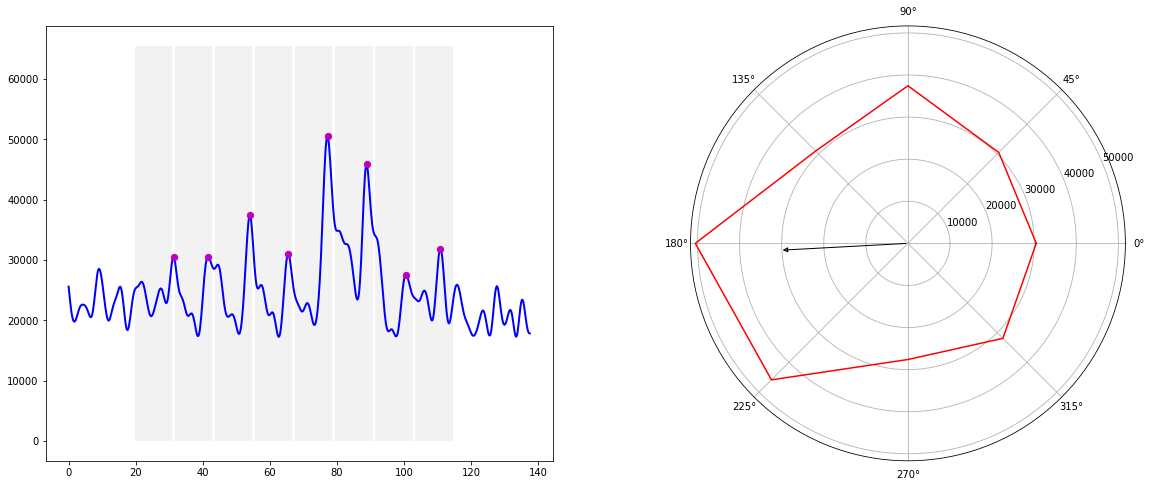

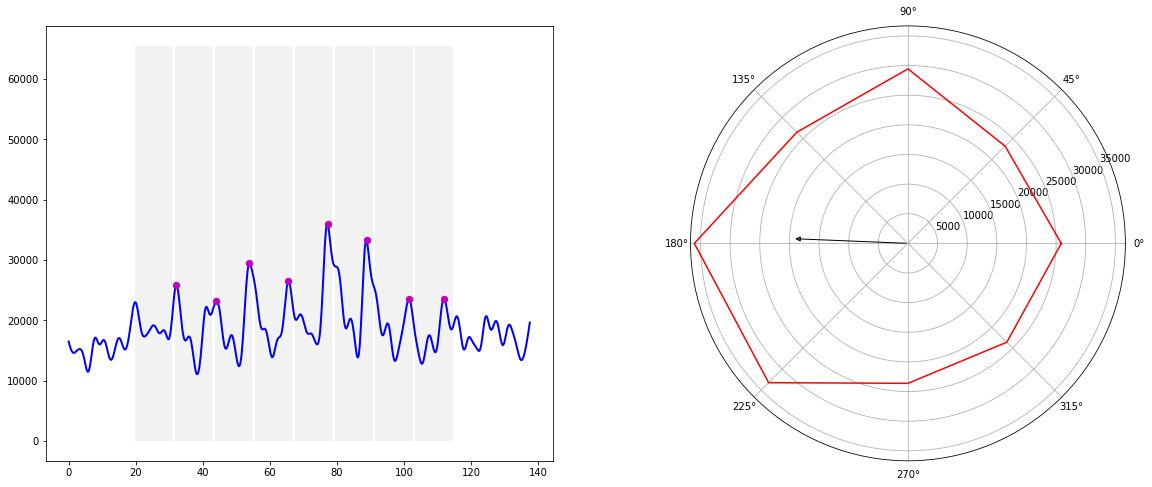

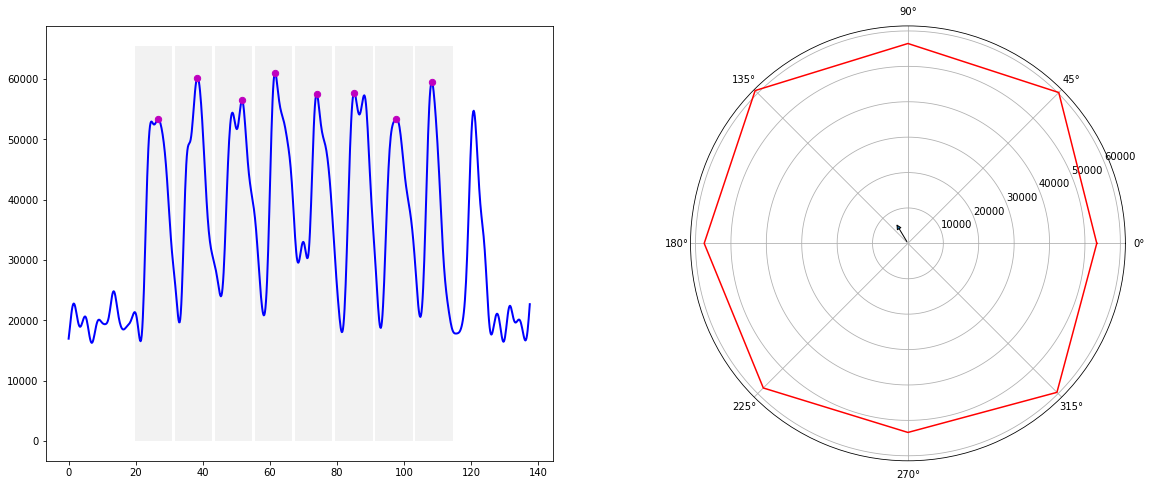

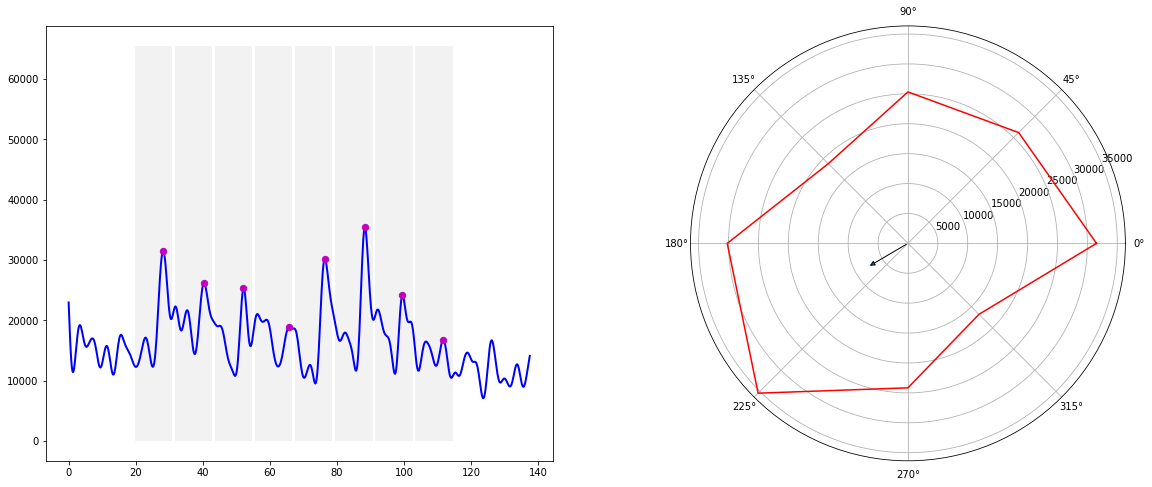

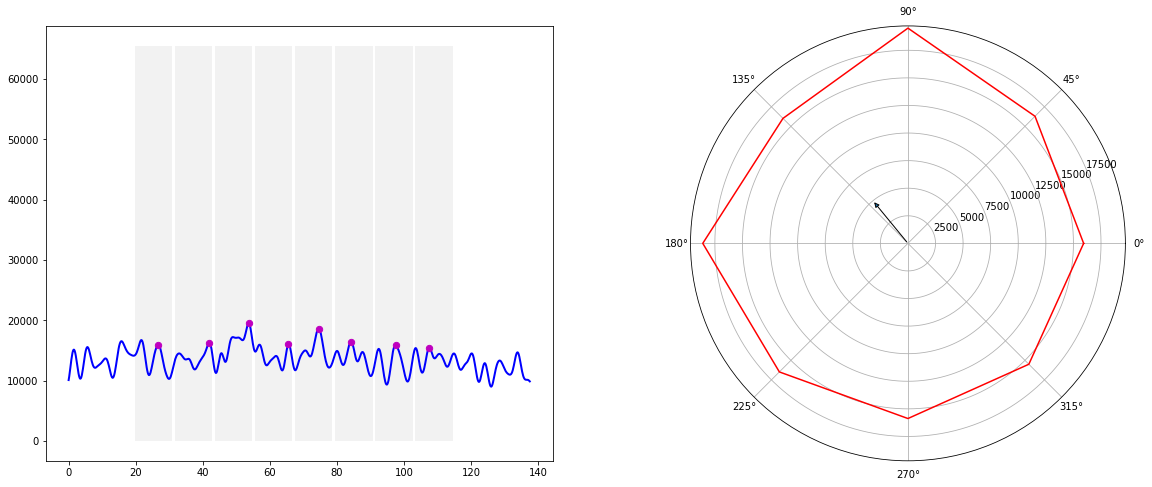

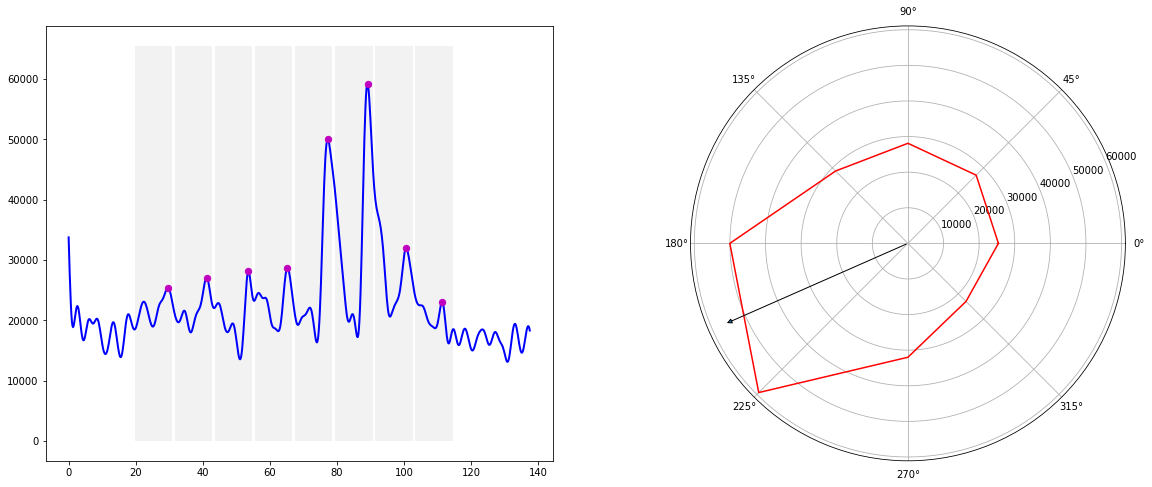

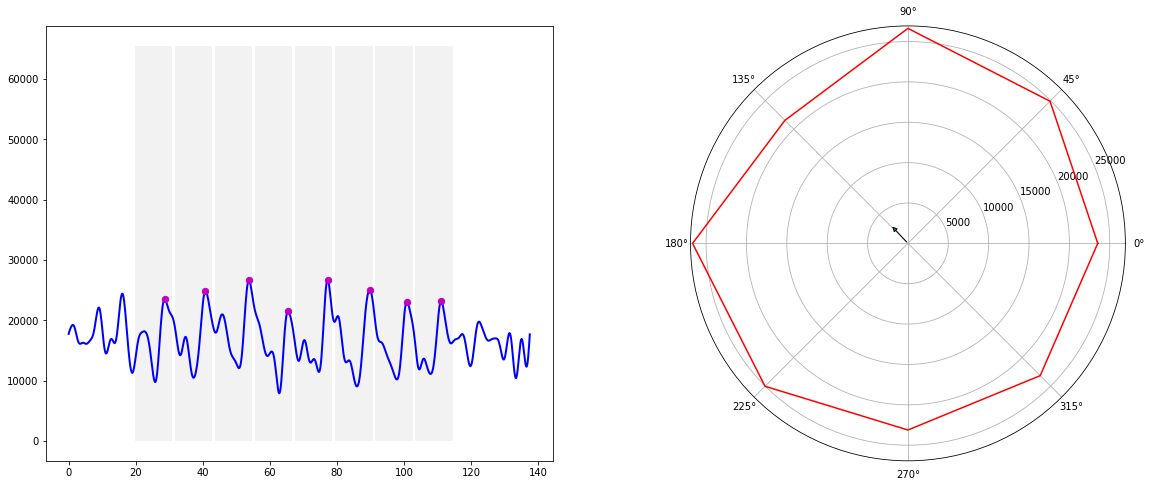

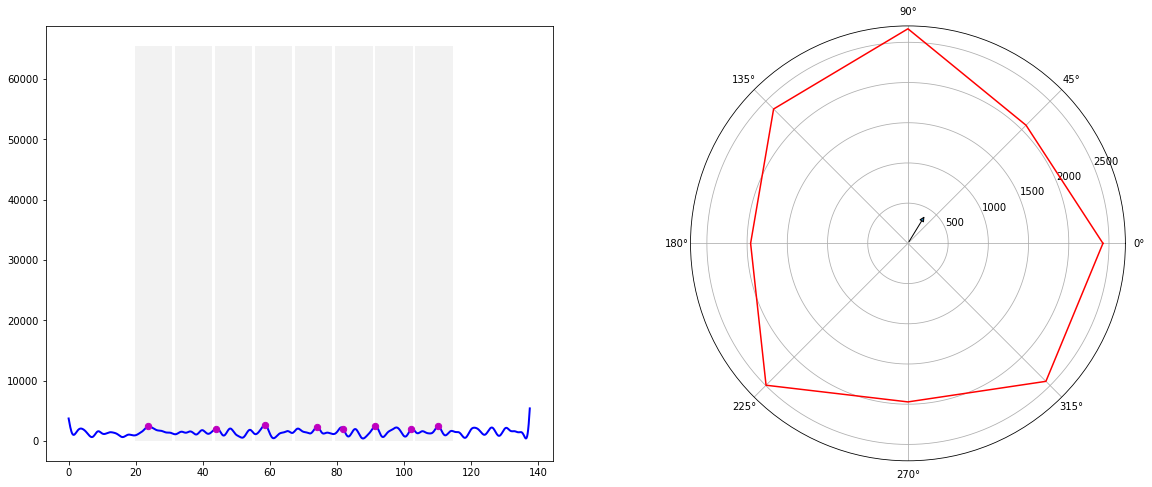

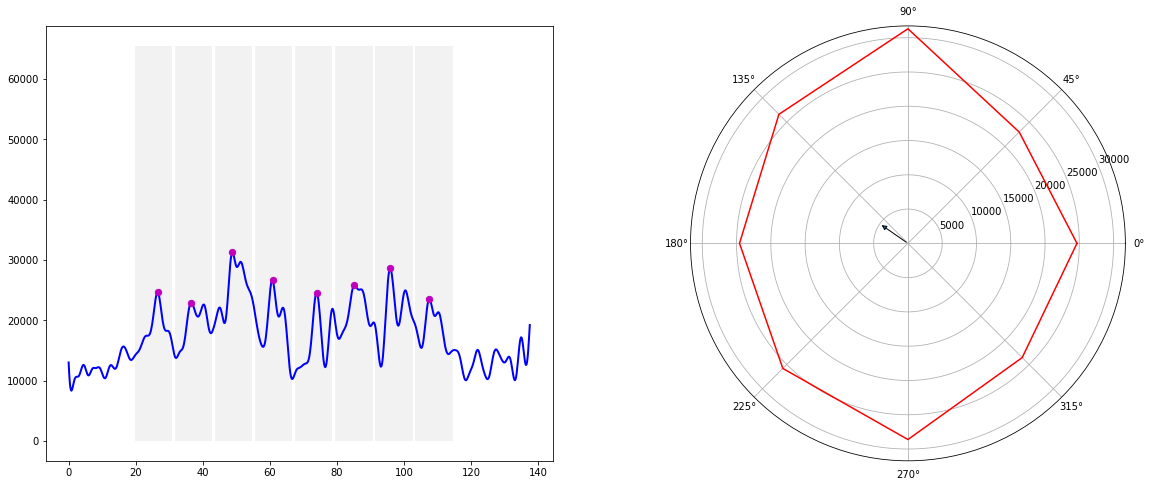

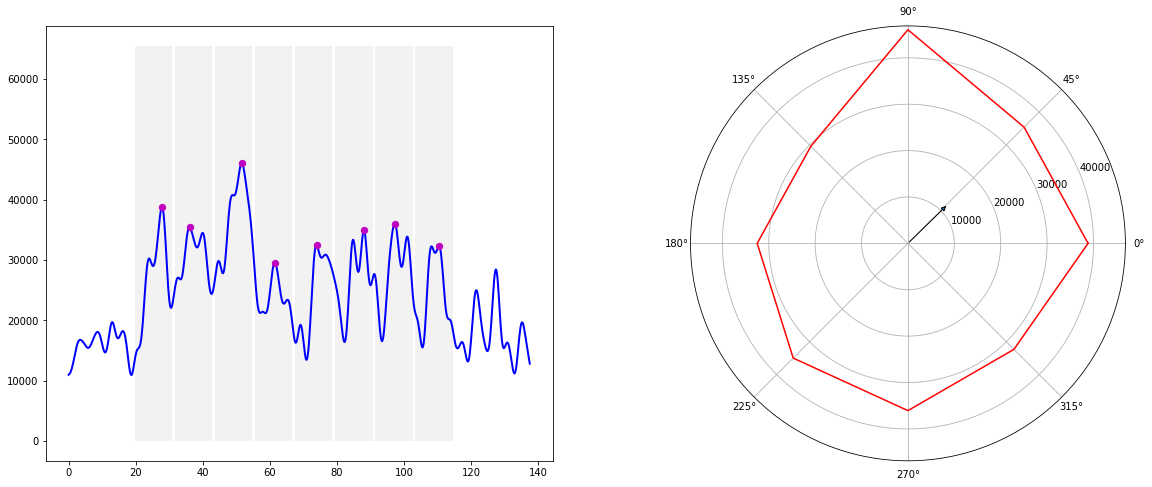

In [74]:
ts = rgTiff(fpath,fname)
print(np.shape(ts.getData()))
# importlib.reload(tst)
# ts.metadata['Lt'] #sampling interval
# ts.barSettings['theta'][1]
# ts.findPeaks(ts.getData()[:,98,78])
bS = ts.getBarSettings()
print(bS['barLims'])
ts.plotPeaks_single(y = 98, x = 78) # ON layer
ts.plotPeaks_single(y = 59, x = 88) # OFF layer
ts.plotPeaks_single(y = 66, x = 136) # big cell that would be TubD2(+)
ts.plotPeaks_single(y = 96, x = 31) # ON layer
ts.plotPeaks_single(y = 97, x = 30)
ts.plotPeaks_single(y = 56, x = 122)
ts.plotPeaks_single(y = 66, x = 203)
ts.plotPeaks_single(y = 70, x = 93)
ts.plotPeaks_single(y = 90, x = 90) # ON layer DS pixel
ts.plotPeaks_single(y = 98, x = 59)
ts.plotPeaks_single(y = 115, x = 78)
ts.plotPeaks_single(y = 55, x = 95)
ts.plotPeaks_single(y = 60, x = 97)

# ts.plotPeaks_single(y = 5, x = 5)
# ts.plotPeaks_single(y = 119, x = 246)


In [16]:
cmap = cmocean.cm.phase

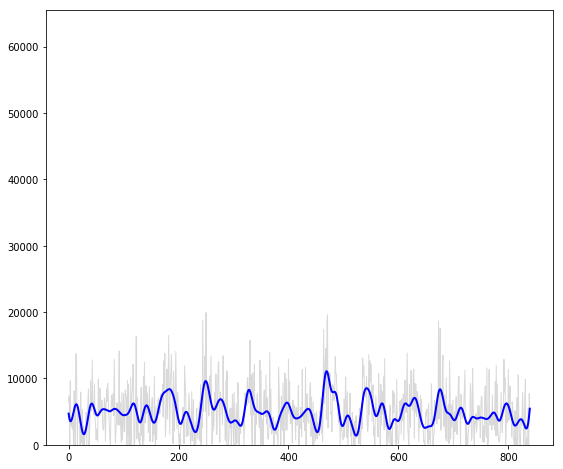

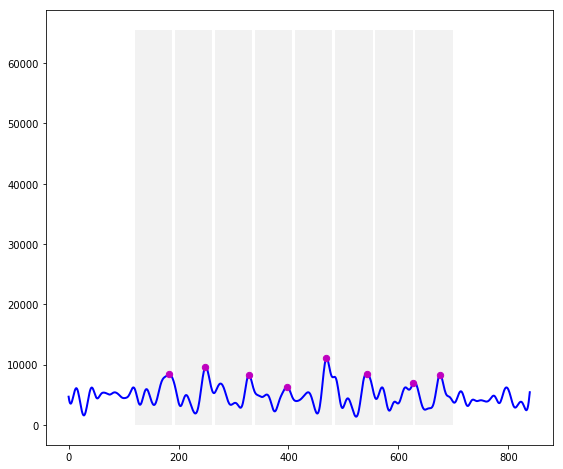

In [70]:
# y = 98; x = 78; # ON layer
y = 59; x = 88; # OFF layer
# y = 66; x = 136; # big cell that would be TubD2(+)
# y = 96; x = 31; # ON layer
# y = 90; x = 90; # ON layer
y = 99; x = 71; # ON layer
data = ts.getData()[:,y,x]
fData = ts.filterData(data);
tAx = ts.getTAxis();
tAx = np.arange(np.size(data));
fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(tAx, data, lw=1, c='k', alpha = .15)
plt.plot(tAx, fData, lw=2, c='b')
plt.ylim([0,np.power(2,16)])
# plt.xlim([400,600])




peakInd = ts.findPeaks(data);
fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(tAx, fData, lw=2, c='b')
for b in range(ts.barSettings['nDirections']):
    rect = matplotlib.patches.Rectangle((ts.barSettings['barLims'][b],0),
                                        ts.barSettings['barW'],
                                        np.power(2,16),linewidth=1,edgecolor='none',facecolor='grey', alpha =.1)
    ax.add_patch(rect)
plt.scatter(tAx[peakInd], fData[peakInd], s=40, c='m', zorder=1000)

## DS across image

In [ ]:
ts = rgTiff(fpath,fname)

In [75]:
ts.getDSimg();

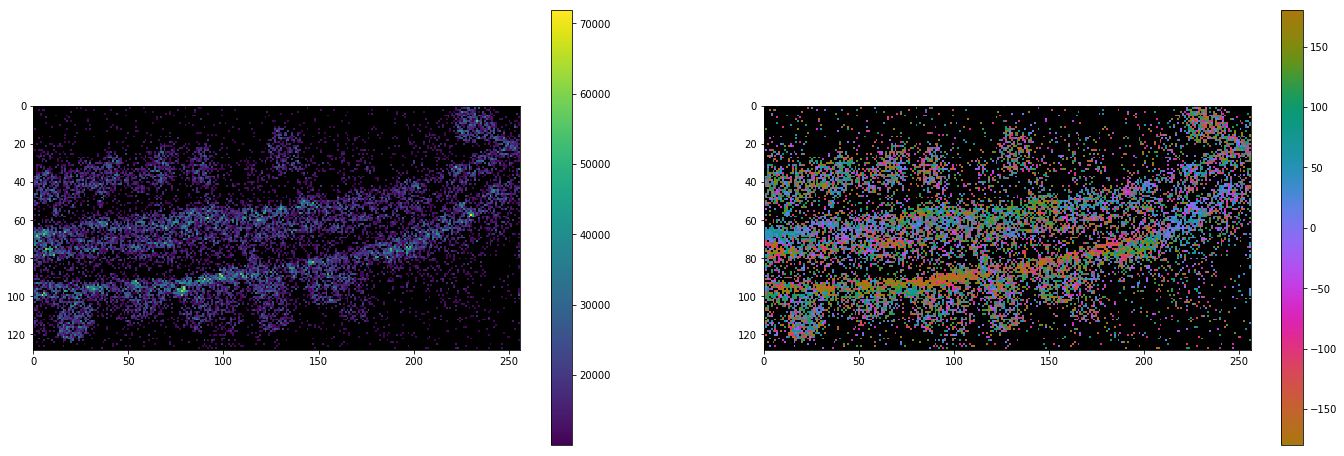

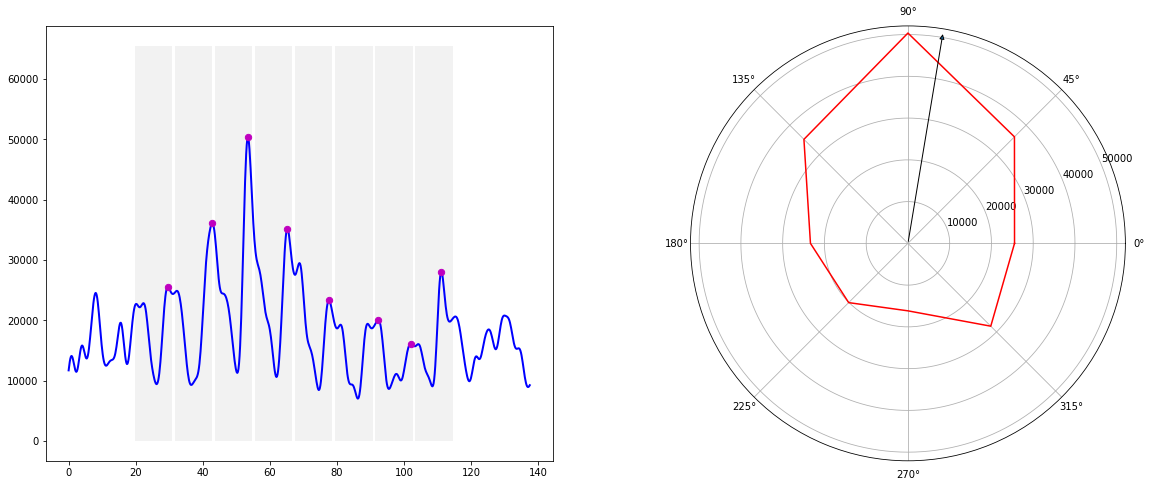

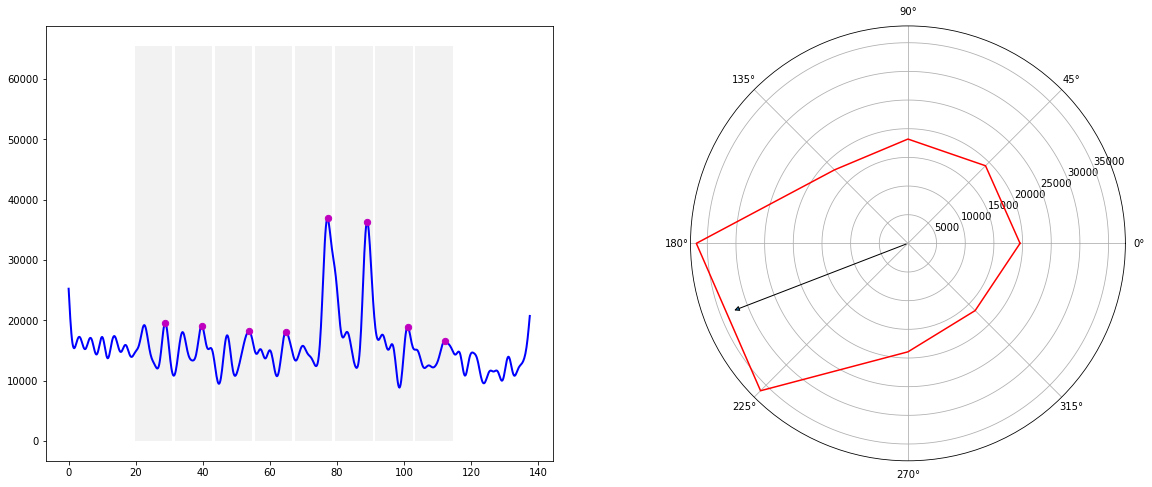

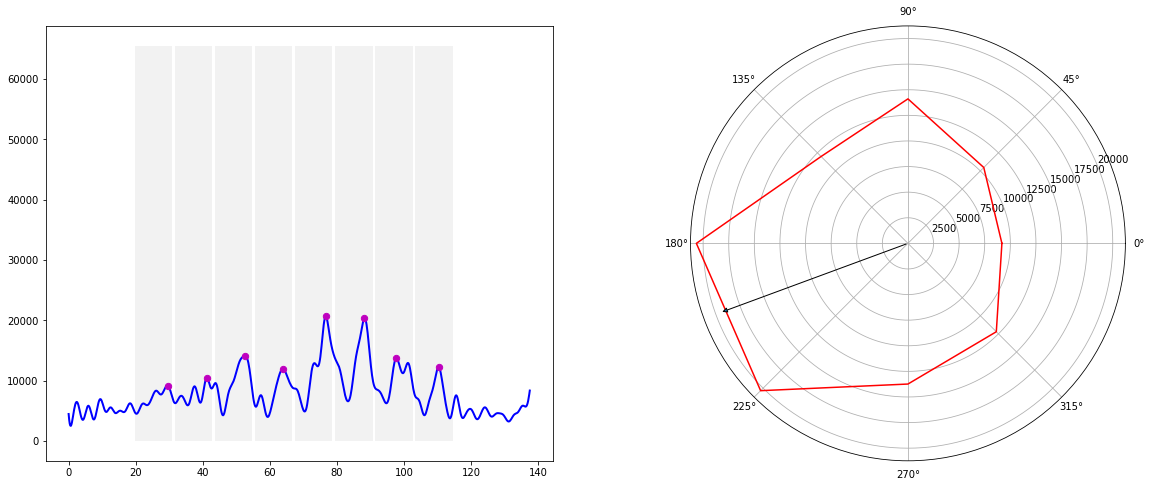

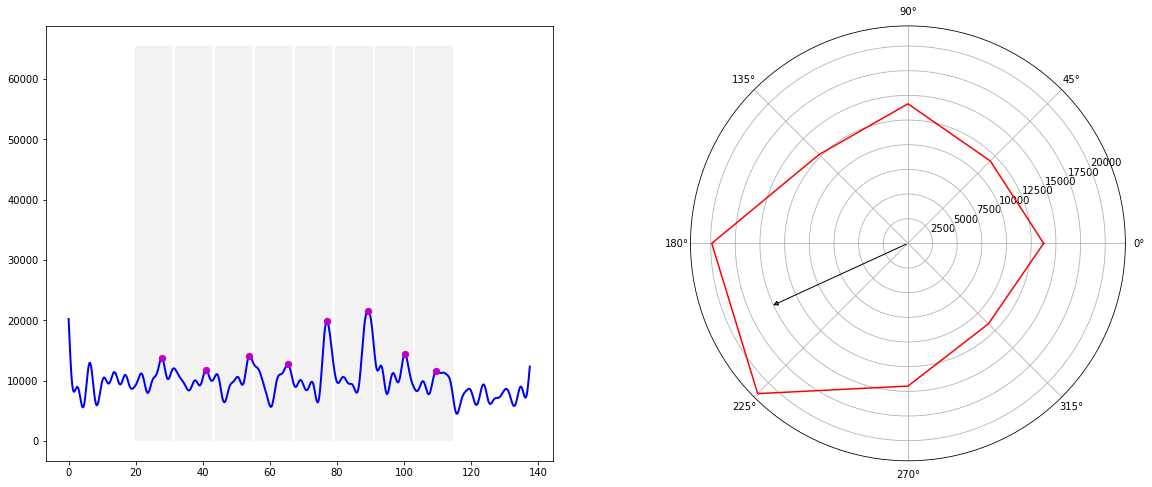

In [120]:
xLims = [0,256]; yLims = [128,0]
# xLims = [0,50]; yLims = [128,60]
# xLims = [60,120]; yLims = [110,80]

# threshold = 30000
threshold = 10000

imgR = ts.dsR
imgT = np.degrees(ts.dsT)
mask = imgR > threshold
plt.figure(figsize=(24, 8))
ax = plt.subplot(1, 2, 1)
ax.set_facecolor('k')
plt.imshow(np.ma.masked_where(mask==0,imgR))
plt.colorbar()
plt.xlim(xLims)
plt.ylim(yLims)
ax = plt.subplot(1, 2, 2)
ax.set_facecolor('k')
# plt.imshow(imgT, cmap = cmap)
# plt.imshow(imgT[mask])
# plt.imshow(np.ma.masked_where(mask==False,mask), cmap = 'Greys', alpha=1)
plt.imshow(np.ma.masked_where(mask==0,imgT), cmap = cmap, alpha=1)
plt.colorbar()
plt.xlim(xLims)
plt.ylim(yLims)

# ts.plotPeaks_single(x = 3, y = 73) # still fail of peak detection
ts.plotPeaks_single(x = 79, y = 96) # DS
ts.plotPeaks_single(x = 90, y = 92) # DS
ts.plotPeaks_single(x = 97, y = 88) # DS
ts.plotPeaks_single(x = 110, y = 90) # DS

In [25]:
help(np.ma.masked_where)

Help on function masked_where in module numpy.ma.core:

masked_where(condition, a, copy=True)
    Mask an array where a condition is met.
    
    Return `a` as an array masked where `condition` is True.
    Any masked values of `a` or `condition` are also masked in the output.
    
    Parameters
    ----------
    condition : array_like
        Masking condition.  When `condition` tests floating point values for
        equality, consider using ``masked_values`` instead.
    a : array_like
        Array to mask.
    copy : bool
        If True (default) make a copy of `a` in the result.  If False modify
        `a` in place and return a view.
    
    Returns
    -------
    result : MaskedArray
        The result of masking `a` where `condition` is True.
    
    See Also
    --------
    masked_values : Mask using floating point equality.
    masked_equal : Mask where equal to a given value.
    masked_not_equal : Mask where `not` equal to a given value.
    masked_less_equal : Mas

In [ ]:
ts.dsT

#### TestPlotter

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(tAx[prepts:prepts+stmpts], aF[prepts:prepts+stmpts], lw=2, c='b')

In [ ]:
img = tst.getMean(ts.getData())
fig, ax = skimage.filters.try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
help (math.cos)

https://math.stackexchange.com/questions/1365622/adding-two-polar-vectors


# DeBug explorations

In [ ]:
maskMul,maskOffset,cfRefImg = register.prepare_masks(refImg,ops)
refAndMasks = [maskMul,maskOffset,cfRefImg]
aligned_data, yshift, xshift, corrXY, yxnr = register.phasecorr(ts.rescale(), refAndMasks, ops)

In [ ]:
ts.plotHistogram(test_ops['refImg']);

In [ ]:
## Trying to ectract data from a single pixel, calculate DS and plot
# several methods to detect peaks failes

# metadata that is needed
sI = 1/ts.metadata['samplingRate']; #sampling interval
prepts = 120;
stmpts = 580;
tailpts = 120;

nDirections = 8;
barW = 68;
bar0 = 120; #bar0 = prepts;
barIBI = 5;

theta0 = 0;
theta = np.delete(np.mod(np.linspace(0+theta0,(2*np.pi)+theta0, num=nDirections+1),(2*np.pi)),-1)


# a = ts.getData()[:,57,123] # data ON example
# a = ts.getData()[:,61,79] # data
# a = ts.getData()[:,87,113] # data
a = ts.getData()[:,98,78] # data OFF example
# a = ts.getData()[:,120,78] # data NOISE example

c = ts.getData()[:,57,123] # data
b = tst.getTSeries(ts.getData()[:,104:128,226:256]) # stimulus artifact
bf_poles, bf_freq = signal.butter(1, .1, btype='low', analog=False, output='ba', fs=None) #butterworth filter
aF = signal.filtfilt(bf_poles, bf_freq,a)
cF = signal.filtfilt(bf_poles, bf_freq,c)
bF = signal.filtfilt(bf_poles, bf_freq,b)

tAx = ts.getTAxis();
tAx = np.arange(np.size(a));

fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)

# plt.plot(tAx, a, lw=2)

plt.plot(tAx, aF, lw=2, c='b')
plt.plot(tAx, cF, lw=2, c='g', alpha=0.2)
plt.plot(tAx, tst.norm16bit(bF), lw=2, c=[0,0,0,.5], alpha=0.2)


barLims = np.multiply(range(nDirections+1),barW)+bar0
barLims = barLims + np.multiply(range(nDirections+1),barIBI)


# this method is fooled by photon noise
# peakInd = signal.find_peaks_cwt(aF[prepts:prepts+stmpts], np.ones(9)*15) 
# peakInd = peakInd + prepts
# this method is not robust in noisy pixels with little to no response
# peakInd, [] = signal.find_peaks(aF[prepts:prepts+stmpts], distance=60)
# peakInd = peakInd + prepts

for b in range(nDirections):
    rect = matplotlib.patches.Rectangle((barLims[b],0),barW,np.power(2,16),linewidth=1,edgecolor='none',facecolor='grey', alpha =.1)
    ax.add_patch(rect)

# probably best is just to find max for each bar presentation
peakInd = np.zeros([nDirections], dtype = int)
aTemp = np.array(aF[prepts:prepts+stmpts], copy=True) 
for b in range(nDirections):
#     # this algorithm is not robust to ON vs OFF
#     # peakInd[b] = np.argmax(aF[barLims[b]:barLims[b+1]])+barLims[b]
#     # iterative peak finding by blanking out data near peak
    peakInd[b] = np.argmax(aTemp)
    print(b, ':',peakInd[b])
    aTemp[peakInd[b]-round(barW/2):peakInd[b]+round(barW/2)]=0
    if peakInd[b] < barW + barIBI:
        aTemp[0:barW + barIBI]=0
#     plt.plot(tAx[prepts:prepts+stmpts], aTemp, lw=2, c='r', alpha = 1-b/nDirections)

# plt.xlim(100, 200)
peakInd = np.sort(peakInd)
peakInd = peakInd + prepts
print(peakInd)

plt.scatter(tAx[peakInd], aF[peakInd], s=40, c='m', zorder=1000)
# peakInd = signal.find_peaks_cwt(bF, np.ones(8)*10)
# plt.scatter(tAx[peakInd], tst.norm16bit(bF)[peakInd], s=40, c='k')
# plt.scatter(tAx[peakInd], tst.norm16bit(bF)[peakInd], s=40, c=np.array([0,0,0,0.5]))


ax = plt.subplot(1, 2, 2, projection='polar')
plt.polar(np.concatenate((theta,[theta[0]])), np.concatenate((aF[peakInd],[aF[peakInd][0]])), 'r-')
# for x, y in zip(theta, aF[peakInd]):
#     plt.polar(x, y, 'ro-')
vsR, vsT = vectorSum(aF[peakInd],theta);
# plt.polar(vsT,vsR,'ro')
# plt.arrow(0,0,vsT,vsR, head_width=.1, head_length=1, length_includes_head=True, head_starts_at_zero=True, fc='k', ec='k')
plt.annotate("", xy=(0, 0), xytext=(vsT, vsR), arrowprops=dict(arrowstyle="<|-"))
    

# w = skimage.morphology.watershed(bF[prepts:prepts:stmpts],markers=8)
# print(np.shape(w))
# skimage.morphology.watershed(image, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)

## Using cross correlation to get peaks

1. need to get template for detection
1. then use cross corealtion to get peak of lag
1. then lay down integration columns (&alpha; bar)